In [125]:
#importo tutti i pacchetti che mi serviranno per l'analisi

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

In [126]:
#considero Leonardo, stock inserita nel segmento aerospaziale e difesa, per analizzare il suo andamento post scoppio della guerra in Ucraina

stock = yf.download ('LDO.MI',dt.datetime(2021,1,1),dt.datetime.today())

[*********************100%***********************]  1 of 1 completed


In [127]:
#solite info utili

ticker = yf.Ticker('LDO.MI')
ticker.info


{'address1': 'Piazza Monte Grappa n. 4',
 'city': 'Rome',
 'state': 'RM',
 'zip': '00195',
 'country': 'Italy',
 'phone': '39 06 324731',
 'fax': '39 06 3208621',
 'website': 'https://www.leonardo.com/en/home',
 'industry': 'Aerospace & Defense',
 'industryKey': 'aerospace-defense',
 'industryDisp': 'Aerospace & Defense',
 'sector': 'Industrials',
 'sectorKey': 'industrials',
 'sectorDisp': 'Industrials',
 'longBusinessSummary': 'Leonardo S.p.a., an industrial and technological company, engages in the helicopters, defense electronics and security, cyber security and solutions, aircraft, aerostructures, and space sectors in Italy, the United Kingdom, rest of Europe, the United States of America, and internationally. The company offers a range of helicopters for battlefield/personnel recovery, combat, maritime, training, VIP/executive transport, medical and rescue, energy, security, and utility services, as well as provides support and training services. It also provides trainers, fighte

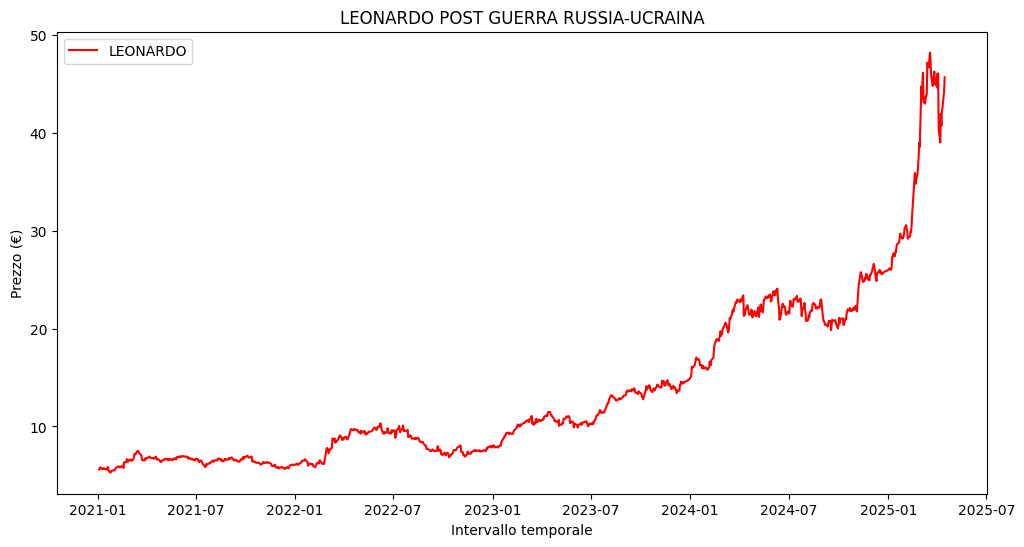

In [128]:
#grafico di Leonardo

plt.figure(figsize=(12,6))
plt.plot(stock.index, stock['Close'], label='LEONARDO', color='red')
plt.title('LEONARDO POST GUERRA RUSSIA-UCRAINA')
plt.xlabel('Intervallo temporale')
plt.ylabel('Prezzo (€)')
plt.legend()
plt.show()

In [129]:
#calcoliamo rendimento logaritmico, la media indicizzata e il rendimento annuo approssimato 

close_prices = stock['Close']
stock['Log Return'] = np.log(close_prices / close_prices.shift(1))
mean_period = stock['Log Return'].mean()
print("=== Rendimento medio logaritmico giornaliero ===")
print(f"2024  → {mean_period:.6f}")
print("\n=== Rendimento medio logaritmico annuo (approssimato) ===")
print(f"2024  → {mean_period * 252:.4%}")


=== Rendimento medio logaritmico giornaliero ===
2024  → 0.001922

=== Rendimento medio logaritmico annuo (approssimato) ===
2024  → 48.4314%


In [130]:
#Adesso, calcoliamo il parametro risk-free per il nostro intervallo temporale, e infine lo sharpe.

df = pd.read_csv("btp.csv.csv", sep=';') 

#Pulisco i nomi delle colonne (opzionale ma utile)
df.columns = df.columns.str.strip()

#Converto la colonna "Data" in formato datetime
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)

#Pulisco la colonna "Ultimo" e la converto in float
df["Rendimento"] = df["Ultimo"].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

df_filtrato = df[df["Data"] >= "2021-01-01"]
media_rendimento = df_filtrato["Rendimento"].mean()
print(f"Media rendimento BTP 10Y dal 1° gennaio 2021 ad oggi: {media_rendimento:.2f}%")
mean_return = df_filtrato["Rendimento"].mean()
std_dev = df_filtrato["Rendimento"].std()
sharpe = mean_return / std_dev if std_dev != 0 else np.nan
print(f"Sharpe Ratio: {sharpe:.2f}")


Media rendimento BTP 10Y dal 1° gennaio 2021 ad oggi: 3.11%
Sharpe Ratio: 2.30


In [131]:
#passiamo al Beta e all'alpha di Jensen. Il riferimento qui è il FTSE MIB

ftsemib = yf.download('FTSEMIB.MI', start='2021-01-01', interval='1d', progress=False)
ftsemib['Log Return Market'] = np.log(ftsemib['Close'] / ftsemib['Close'].shift(1))
ftsemib = ftsemib[['Log Return Market']].dropna()
leonardo_return = stock['Log Return'] 

#Pulizia colonne del FTSEMIB se ha MultiIndex
if isinstance(ftsemib.columns, pd.MultiIndex):
    ftsemib.columns = ftsemib.columns.get_level_values(0)
#Merge su base mensile (entrambe con indice datetime). Merge serve per mettere insieme informazioni da fonti diverse
df = pd.merge(leonardo_return.to_frame('stock_return'), ftsemib[['Log Return Market']],left_index=True, right_index=True, how='inner')
df.dropna(inplace=True)

# Regressione OLS: calcolo Beta e Alpha
if df.empty:
    print("⚠️ Nessun dato disponibile per la regressione.")
else:
    X = sm.add_constant(df['Log Return Market'])
    y = df['stock_return']
    model = sm.OLS(y, X).fit()
    beta = model.params['Log Return Market']
    alpha = model.params['const']

    print(f"Beta di Leonardo: {beta:.4f}")
    print(f"Alpha: {alpha:.4f}")
    print(model.summary())

#Il modello CAPM stimato per Leonardo restituisce un alpha positivo e statisticamente significativo, suggerendo una sovraperformance giornaliera dello 0.16% rispetto al mercato. 
#Anche il beta è significativo, tuttavia il modello spiega solo il 14% della varianza nei rendimenti

Beta di Leonardo: 0.6842
Alpha: 0.0016
                            OLS Regression Results                            
Dep. Variable:           stock_return   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     182.7
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           1.34e-38
Time:                        13:50:27   Log-Likelihood:                 2739.2
No. Observations:                1092   AIC:                            -5474.
Df Residuals:                    1090   BIC:                            -5464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

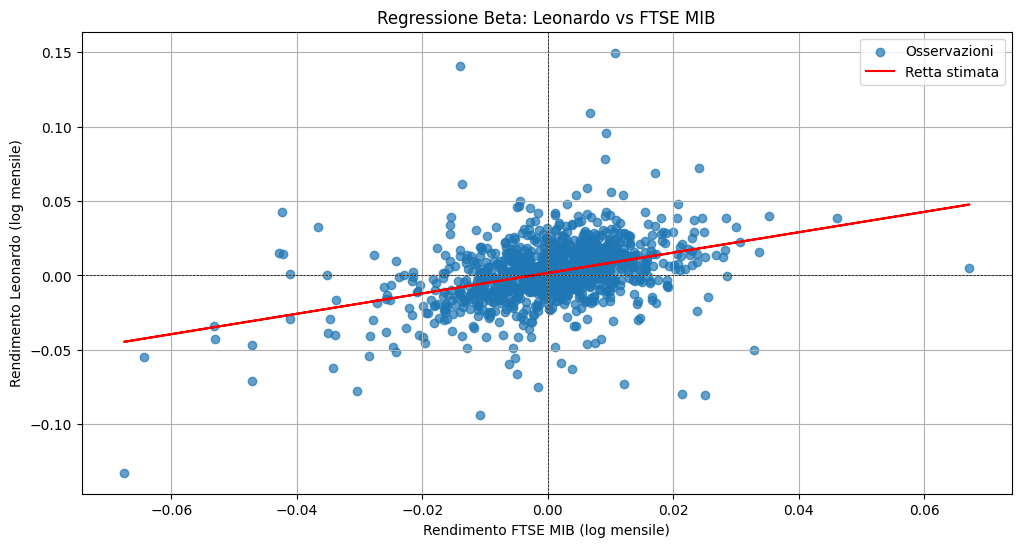

In [132]:
plt.figure(figsize=(12,6))
plt.scatter(df['Log Return Market'], df['stock_return'], alpha=0.7, label='Osservazioni')
plt.plot(df['Log Return Market'], model.predict(X), color='red', label='Retta stimata')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Rendimento FTSE MIB (log mensile)')
plt.ylabel('Rendimento Leonardo (log mensile)')
plt.title('Regressione Beta: Leonardo vs FTSE MIB')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
#Siccome l'R^2 è molto basso, ho calcolato la correlazione della stock con un ETF settoriale, iShares Aerospace & Defense (ITA), per vedere se fitta meglio

ita = yf.download('ITA', start='2021-01-01', interval='1d', progress=False)
ita['Log Return ITA'] = np.log(ita['Close'] / ita['Close'].shift(1))
ita = ita[['Log Return ITA']].dropna()
leonardo_return = stock[('Log Return')]

# Se ITA ha colonne MultiIndex, semplifico
if isinstance(ita.columns, pd.MultiIndex):
    ita.columns = ita.columns.get_level_values(0)
    
# Merge su indice temporale mensile
df = pd.merge( leonardo_return.to_frame('stock_return'), ita[['Log Return ITA']], left_index=True, right_index=True, how='inner')
df.dropna(inplace=True)

#Regressione
if df.empty:
    print("⚠️ Nessun dato disponibile per la regressione.")
else:
    X = sm.add_constant(df['Log Return ITA'])
    y = df['stock_return']
    model = sm.OLS(y, X).fit()
    beta = model.params['Log Return ITA']
    alpha = model.params['const']

    print(f"📈 Beta settoriale di Leonardo con riferimento ETF ITA: {beta:.4f}")
    print(f"⚙️ Alpha: {alpha:.4f}")
    print(f"📊 R²: {model.rsquared:.2%}")

print(model.summary())


📈 Beta settoriale di Leonardo con riferimento ETF ITA: 0.4898
⚙️ Alpha: 0.0016
📊 R²: 8.58%
                            OLS Regression Results                            
Dep. Variable:           stock_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     99.28
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           2.05e-22
Time:                        13:50:28   Log-Likelihood:                 2628.6
No. Observations:                1060   AIC:                            -5253.
Df Residuals:                    1058   BIC:                            -5243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [134]:
ftse = ftsemib[['Log Return Market']].rename(columns={'Log Return Market': 'FTSE MIB'})
ita_ = ita[['Log Return ITA']].rename(columns={'Log Return ITA': 'ITA'})
#Merge dei tre dataframe su indice temporale
df_corr = leonardo.join([ftse, ita_], how='inner').dropna()
correlation_matrix = df_corr.corr()

corr_vs_ftse = correlation_matrix.loc['Leonardo', 'FTSE MIB']
corr_vs_ita = correlation_matrix.loc['Leonardo', 'ITA']

print(f"📈 Correlazione Leonardo – FTSE MIB: {corr_vs_ftse:.4f}")
print(f"📈 Correlazione Leonardo – ETF ITA: {corr_vs_ita:.4f}")

#La correlazione è più bassa, infatti anche l'R^2 è più basso. Ci facciamo andar bene il BETA con riferimento FTSE MIB


📈 Correlazione Leonardo – FTSE MIB: 0.3758
📈 Correlazione Leonardo – ETF ITA: 0.2929


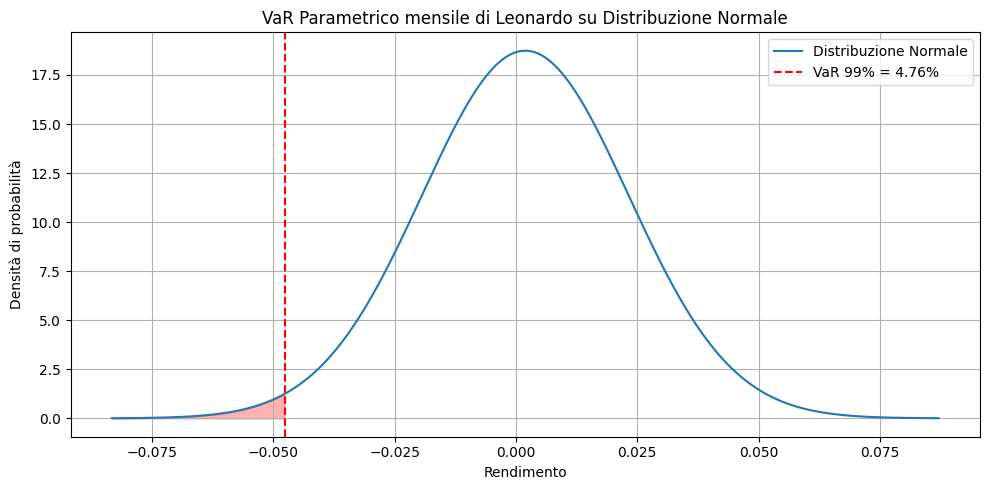

In [135]:
#VAR Parametrico

mean_return = leonardo_return.mean()
std_dev = leonardo_return.std()
confidence_level = 0.99
z = norm.ppf(1 - confidence_level)
var = -(mean_return + z * std_dev)

#Genera curva gaussiana
x = np.linspace(mean_return - 4*std_dev, mean_return + 4*std_dev, 1000)
y = norm.pdf(x, mean_return, std_dev)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Distribuzione Normale')
plt.axvline(-var, color='red', linestyle='--', label=f'VaR {int(confidence_level*100)}% = {var:.2%}')
plt.fill_between(x, y, 0, where=(x <= -var), color='red', alpha=0.3)

plt.title('VaR Parametrico mensile di Leonardo su Distribuzione Normale')
plt.xlabel('Rendimento')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📉 VaR storico mensile (Leonardo) a 99%: 5.9937%


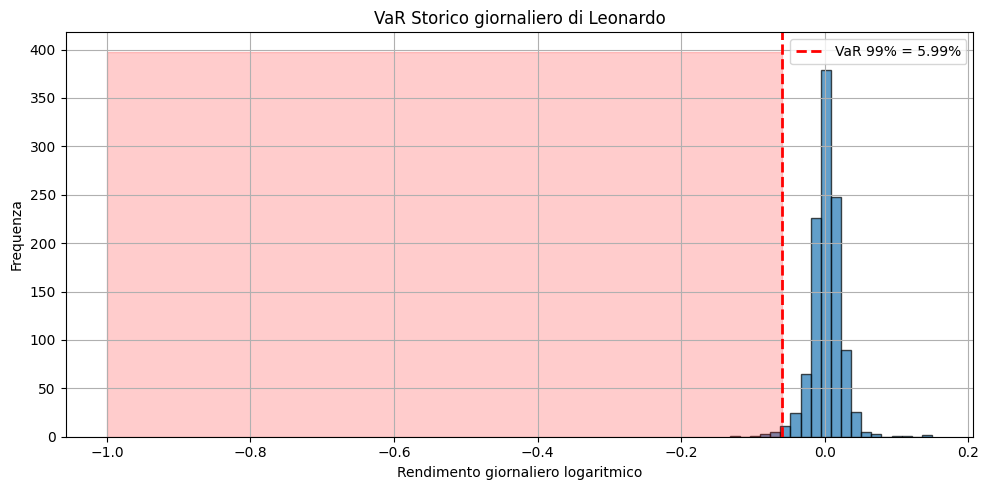

In [136]:
#VAR Storico
confidence_level = +0.99
start_date = '2021-01-01'
leonardo_return=leonardo_return.dropna()
var_storico = -np.percentile(leonardo_return, (1 - confidence_level) * 100)

print(f"📉 VaR storico mensile (Leonardo) a {int(confidence_level*100)}%: {var_storico:.4%}")

plt.figure(figsize=(10,5))
plt.hist(leonardo_return, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(-var_storico, color='red', linestyle='--', linewidth=2, label=f'VaR {int(confidence_level*100)}% = {var_storico:.2%}')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], -1, -var_storico, color='red', alpha=0.2)

plt.title('VaR Storico giornaliero di Leonardo')
plt.xlabel('Rendimento giornaliero logaritmico')
plt.ylabel('Frequenza')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [137]:
leonardo_return.head()

Date
2021-01-05    0.024400
2021-01-06    0.014623
2021-01-07   -0.008615
2021-01-08   -0.015764
2021-01-11   -0.006784
Name: Log Return, dtype: float64

📉 VaR Monte Carlo mensile (Leonardo) a 99%: 4.9322%


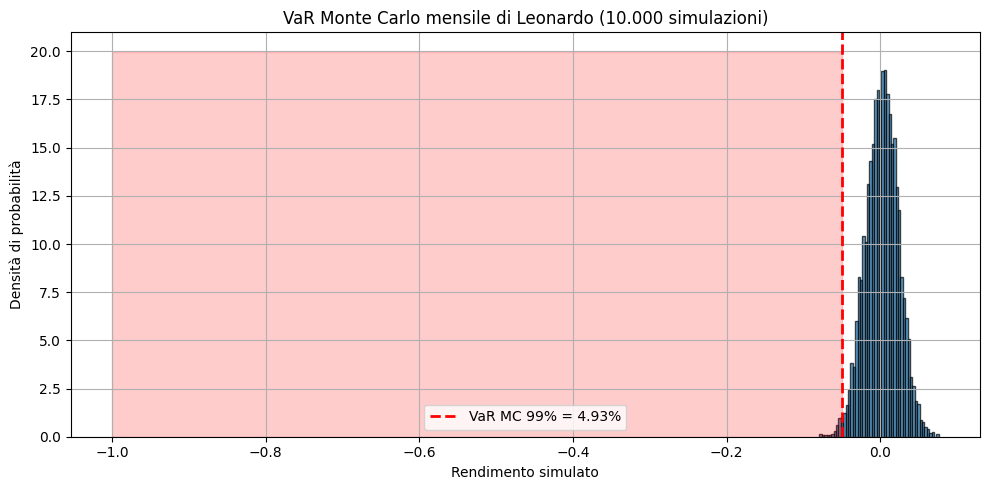

In [138]:
#VAR Montecarlo
confidence_level = 0.99
n_simulations = 10000
start_date = '2021-01-01'


mu = leonardo_return.mean()
sigma = leonardo_return.std()

simulated_returns = np.random.normal(loc=mu, scale=sigma, size=n_simulations)

#Calcolo VaR Monte Carlo
var_mc = -np.percentile(simulated_returns, (1 - confidence_level) * 100)

#Output
print(f"📉 VaR Monte Carlo mensile (Leonardo) a {int(confidence_level*100)}%: {var_mc:.4%}")

#Grafico distribuzione simulata
plt.figure(figsize=(10,5))
plt.hist(simulated_returns, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.axvline(-var_mc, color='red', linestyle='--', linewidth=2, label=f'VaR MC {int(confidence_level*100)}% = {var_mc:.2%}')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], -1, -var_mc, color='red', alpha=0.2)

plt.title('VaR Monte Carlo mensile di Leonardo (10.000 simulazioni)')
plt.xlabel('Rendimento simulato')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📉 Expected Shortfall (ES) giornaliera a 99%: 5.4828%


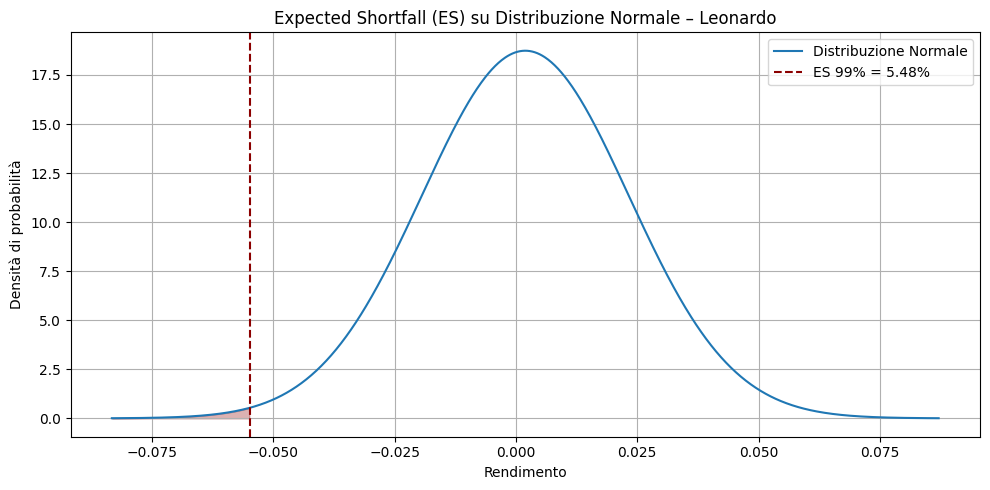

In [139]:
#Calcoliamo l'expected shortfall, che ci dice la perdita media, dato un intervallo di confidenza, se Leonardo subisce una perdita peggiore del VAR.
#In sintesi, il Var è la perdita massima attesa ad un dato intervallo di confidenza, l'ES è una perdita media condizionata al superamento del VAR. 

confidence_level = 0.99
start_date = '2021-01-01'

mu = leonardo_return.mean()
sigma = leonardo_return.std()

#Calcolo z-score e PDF per ES
z = norm.ppf(1 - confidence_level) #Z è il valore sulla normale per l'intervallo di confidenza: per il 95% vale 1.645
phi = norm.pdf(z) #

expected_shortfall = -(mu - sigma * (phi / (1 - confidence_level)))

print(f"📉 Expected Shortfall (ES) giornaliera a {int(confidence_level*100)}%: {expected_shortfall:.4%}")

#Grafico della distribuzione normale con ES ===
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(10,5))
plt.plot(x, y, label='Distribuzione Normale')
plt.axvline(-expected_shortfall, color='darkred', linestyle='--', label=f'ES {int(confidence_level*100)}% = {expected_shortfall:.2%}')
plt.fill_between(x, y, 0, where=(x <= -expected_shortfall), color='darkred', alpha=0.3)

plt.title('Expected Shortfall (ES) su Distribuzione Normale – Leonardo')
plt.xlabel('Rendimento')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
